In [19]:
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

BASE_DIR: str = os.path.abspath(os.getcwd())
DB_DIR: str = os.path.join(BASE_DIR, "database")
CLEAN_DIR: str = os.path.join(DB_DIR, "clean")
MODEL_DIR: str = os.path.join(BASE_DIR, "models")

PATH_TRAIN: str = os.path.join(CLEAN_DIR, "2016-2024_liga_mx_clean.csv")
PATH_TEST_2023: str = os.path.join(CLEAN_DIR, "2016-2023_liga_mx_clean.csv")
PATH_TEST_2022: str = os.path.join(CLEAN_DIR, "2016-2022_liga_mx_clean.csv")
PATH_RAW_2023: str = os.path.join(CLEAN_DIR, "2016-2023_liga_mx_clean.csv")
PATH_RAW_2022: str = os.path.join(CLEAN_DIR, "2016-2022_liga_mx_clean.csv")

In [20]:
df_train = pd.read_csv(PATH_TRAIN)
df_train.shape, df_train.columns.tolist()

((2589, 10),
 ['home_team',
  'away_team',
  'home_win',
  'away_win',
  'home_goals',
  'away_goals',
  'home_goals_half_time',
  'away_goals_half_time',
  'home_goals_fulltime',
  'away_goals_fulltime'])

In [21]:
df_train = df_train.dropna(subset=["home_team", "away_team", "home_goals_fulltime", "away_goals_fulltime"])

df_train["result"] = np.where(
    df_train["home_goals_fulltime"] > df_train["away_goals_fulltime"], "H",
    np.where(df_train["home_goals_fulltime"] < df_train["away_goals_fulltime"], "A", "D")
)

features = ["home_team", "away_team", "home_goals_half_time", "away_goals_half_time"]
df_train = df_train.dropna(subset=features)

X = df_train[features].copy()
y = df_train["result"].copy()

X.shape, y.value_counts(normalize=True)

((2589, 4),
 result
 H    0.454616
 A    0.288915
 D    0.256470
 Name: proportion, dtype: float64)

In [22]:
df_train[["home_goals_half_time","away_goals_half_time","home_goals_fulltime","away_goals_fulltime"]].describe()

,home_goals_half_time,away_goals_half_time,home_goals_fulltime,away_goals_fulltime
count,2589.000000,2589.000000,2589.000000,2589.000000
mean,0.700657,0.539204,1.562379,1.193897
std,0.821609,0.718294,1.234983,1.083219
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000
max,6.000000,5.000000,9.000000,6.000000


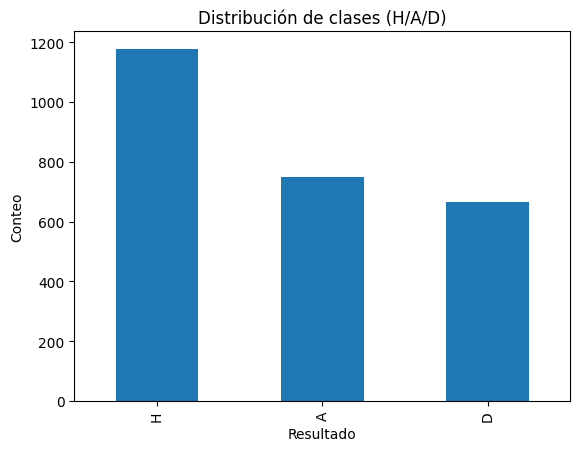

In [23]:
ax = y.value_counts().plot(kind="bar")
ax.set_title("Distribución de clases (H/A/D)")
ax.set_xlabel("Resultado")
ax.set_ylabel("Conteo")
plt.show()

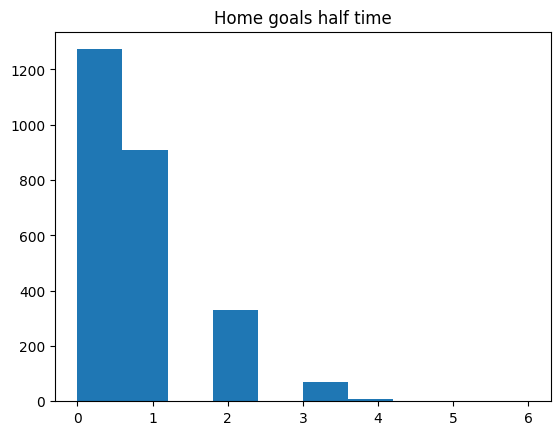

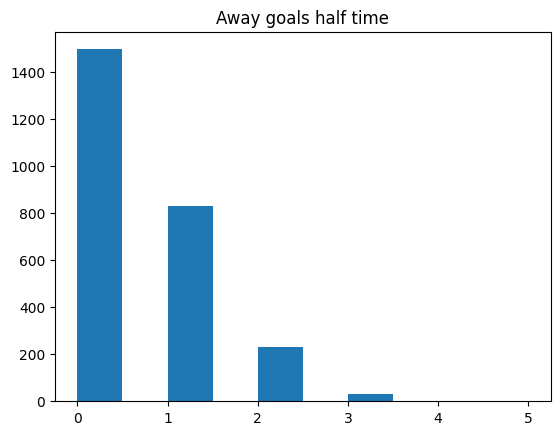

In [24]:
plt.hist(df_train["home_goals_half_time"], bins=10)
plt.title("Home goals half time")
plt.show()

plt.hist(df_train["away_goals_half_time"], bins=10)
plt.title("Away goals half time")
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

X_train.shape, X_test.shape

((2071, 4), (518, 4))

In [26]:
cat_features = ["home_team", "away_team"]
num_features = ["home_goals_half_time", "away_goals_half_time"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
    ],
    remainder="drop"
)

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1_macro"

In [28]:
pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=5000))
])

param_grid_lr = {
    "model__C": [0.1, 1, 10],
    "model__solver": ["lbfgs"],
    "model__class_weight": [None, "balanced"]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_lr.fit(X_train, y_train)
grid_lr.best_params_, grid_lr.best_score_

({'model__C': 0.1,
  'model__class_weight': 'balanced',
  'model__solver': 'lbfgs'},
 np.float64(0.5566146093030133))

In [29]:
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced_subsample"]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)
grid_rf.best_params_, grid_rf.best_score_

({'model__class_weight': 'balanced_subsample',
  'model__max_depth': 10,
  'model__min_samples_split': 5,
  'model__n_estimators': 200},
 np.float64(0.5414050381717936))

In [30]:
candidates = [
    ("LogisticRegression", grid_lr),
    ("RandomForest", grid_rf),
]

best_name, best_grid = max(candidates, key=lambda x: x[1].best_score_)
best_model = best_grid.best_estimator_

best_name, best_grid.best_score_

('LogisticRegression', np.float64(0.5566146093030133))

In [31]:
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

acc, f1m

(0.61003861003861, 0.5950526020144208)

In [32]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           A     0.6467    0.7200    0.6814       150
           D     0.3822    0.4511    0.4138       133
           H     0.7629    0.6298    0.6900       235

    accuracy                         0.6100       518
   macro avg     0.5973    0.6003    0.5951       518
weighted avg     0.6315    0.6100    0.6166       518



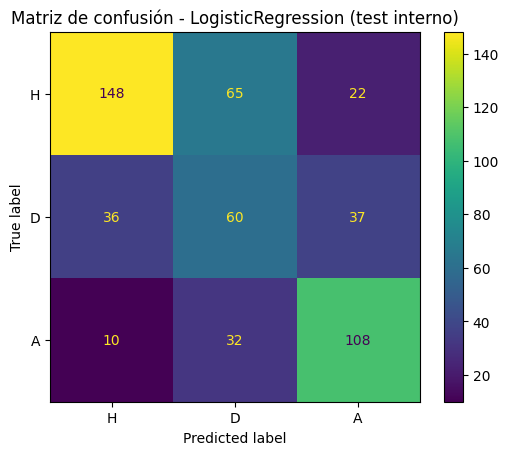

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=["H", "D", "A"])
ConfusionMatrixDisplay(cm, display_labels=["H", "D", "A"]).plot()
plt.title(f"Matriz de confusión - {best_name} (test interno)")
plt.show()

In [34]:
cv_results = pd.DataFrame(best_grid.cv_results_)
best_idx = best_grid.best_index_

mean_train_cv = cv_results.loc[best_idx, "mean_train_score"]
mean_val_cv = cv_results.loc[best_idx, "mean_test_score"]

train_pred = best_model.predict(X_train)
train_f1m = f1_score(y_train, train_pred, average="macro")
test_f1m = f1_score(y_test, y_pred, average="macro")

pd.DataFrame({
    "score": ["mean_train_score(CV)", "mean_val_score(CV)", "train_f1_macro", "test_f1_macro"],
    "value": [mean_train_cv, mean_val_cv, train_f1m, test_f1m]
})

,score,value
0,mean_train_score(CV),0.591702
1,mean_val_score(CV),0.556615
2,train_f1_macro,0.585941
3,test_f1_macro,0.595053


In [35]:
def prepare_xy_from_raw(path: str) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    df = pd.read_csv(path)

    keep_cols = [
        "home_team", "away_team",
        "home_win", "away_win",
        "home_goals", "away_goals",
        "home_goals_half_time", "away_goals_half_time",
        "home_goals_fulltime", "away_goals_fulltime",
    ]

    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()

    score_cols = [
        "home_goals", "away_goals",
        "home_goals_half_time", "away_goals_half_time",
        "home_goals_fulltime", "away_goals_fulltime",
    ]

    for c in score_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["home_team", "away_team", "home_goals_fulltime", "away_goals_fulltime"])

    df["result"] = np.where(
        df["home_goals_fulltime"] > df["away_goals_fulltime"], "H",
        np.where(df["home_goals_fulltime"] < df["away_goals_fulltime"], "A", "D")
    )

    features = ["home_team", "away_team", "home_goals_half_time", "away_goals_half_time"]
    df = df.dropna(subset=features)

    X = df[features].copy()
    y = df["result"].copy()
    return X, y, df

X_2023, y_2023, df_2023 = prepare_xy_from_raw(PATH_RAW_2023)
X_2022, y_2022, df_2022 = prepare_xy_from_raw(PATH_RAW_2022)

def eval_dataset(name: str, model: Pipeline, Xext: pd.DataFrame, yext: pd.Series) -> dict[str, Any]:
    yhat = model.predict(Xext)
    return {
        "dataset": name,
        "n": len(yext),
        "accuracy": accuracy_score(yext, yhat),
        "f1_macro": f1_score(yext, yhat, average="macro")
    }

external_report = pd.DataFrame([
    eval_dataset("RAW 2016-2023", best_model, X_2023, y_2023),
    eval_dataset("RAW 2016-2022", best_model, X_2022, y_2022),
])

external_report

,dataset,n,accuracy,f1_macro
0,RAW 2016-2023,2452,0.604405,0.586493
1,RAW 2016-2022,2153,0.608453,0.592061


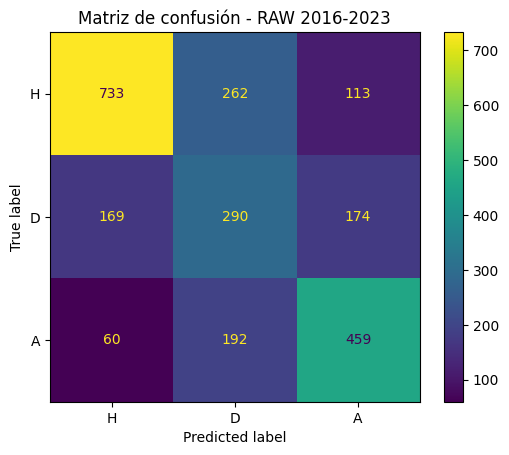

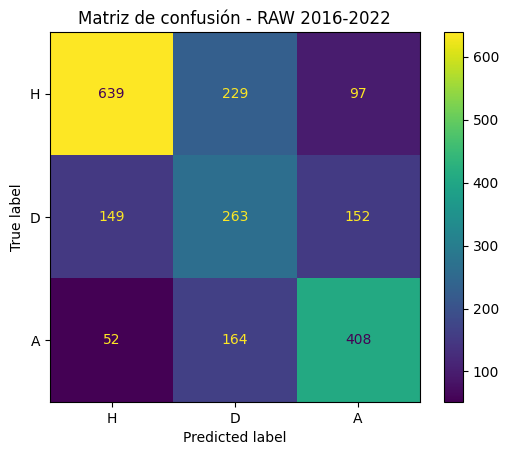

In [36]:
yhat_2023 = best_model.predict(X_2023)
cm_2023 = confusion_matrix(y_2023, yhat_2023, labels=["H", "D", "A"])
ConfusionMatrixDisplay(cm_2023, display_labels=["H", "D", "A"]).plot()
plt.title("Matriz de confusión - RAW 2016-2023")
plt.show()

yhat_2022 = best_model.predict(X_2022)
cm_2022 = confusion_matrix(y_2022, yhat_2022, labels=["H", "D", "A"])
ConfusionMatrixDisplay(cm_2022, display_labels=["H", "D", "A"]).plot()
plt.title("Matriz de confusión - RAW 2016-2022")
plt.show()

In [ ]:
import joblib


os.makedirs(MODEL_DIR, exist_ok=True)


model_filename: str = f"best_model_{best_name}.joblib"
model_path: str = os.path.join(MODEL_DIR, model_filename)
joblib.dump(best_model, model_path)

print(f" Modelo guardado en: {model_path}")
print(f" Modelo: {best_name}")
print(f" Accuracidad (test): {acc:.4f}")
print(f" F1-macro (test): {f1m:.4f}")

✅ Modelo guardado en: c:\Users\rafae\OneDrive\Documents\GitHub\multiprotocol-server-app\training\models\best_model_LogisticRegression.joblib
📊 Modelo: LogisticRegression
📈 Accuracidad (test): 0.6100
🎯 F1-macro (test): 0.5951
